# Classifying simulated events using a CNN

The (binary) multiplicity classification of the 2D CeBr dataset is somewhat similar to MNIST digit classification. The images are smaller (16 × 16 instead of 28 × 28), the number of labels is smaller (1 binary label instead of 10 one-hot labels), but one would expect that models that perform well on the MNIST digit dataset also perform reasonably well on the CeBr dataset.

[Here](https://www.kaggle.com/c/digit-recognizer/discussion/61480) is an overview of the best models for the MNIST data on kaggle. The model with the best accuracy (that does not cheat) is [described here](https://www.kaggle.com/cdeotte/25-million-images-0-99757-mnist).

The approach uses a data augmentation approach that is not applicable to the CeBr dataset. Also, it utilizes an ensemble of 15 CNNs; instead, I opted to use a single CNN.

## Load modules, prepare data

It is expected that the 200k_Mix data set has been prepared using the `data_import_exploration.ipynb` notebook and two files `images_training_200k.npy` and `labels_training_200.npy` are available, that include 160k events.

In [47]:
%matplotlib inline
import warnings
warnings.simplefilter(action='ignore', category=FutureWarning)
from multiprocessing import Pool
import contextlib

import numpy as np
import matplotlib as mpl
import matplotlib.pyplot as plt
import seaborn as sns
import seaborn as sns
import tensorflow as tf
import pandas as pd
from tensorflow.keras.layers import Conv2D, MaxPool2D, Flatten, Dense, Dropout, BatchNormalization
from sklearn.model_selection import train_test_split
from sklearn.metrics import (accuracy_score, confusion_matrix, f1_score, 
                             matthews_corrcoef, roc_curve, roc_auc_score)

def normalize_image_data(images):
    """ Takes an imported set of images and normalizes values to between
    0 and 1 using min-max scaling across the whole image set.
    """
    img_max = np.amax(images)
    img_min = np.amin(images)
    images = (images - img_min) / (img_max - img_min)
    return images

plt.rcParams["figure.figsize"] = (10, 15)
plt.style.use('seaborn')

DATA_PATH = "../data/"

images = np.load(DATA_PATH+"images_training_200k.npy")
labels = np.load(DATA_PATH+"labels_training_200k.npy")
positions = np.load(DATA_PATH+"positions_training_200k.npy")

images = images.reshape(images.shape[0], 16, 16, 1)
print(images.shape)

(160000, 16, 16, 1)


In [2]:
def plot_history(history):
    """ Plots loss, val_loss, accuracy, and val_accuray as two plots
    side-by-side.
    """
    fig, ax = plt.subplots(1, 2, figsize=(14, 6))
    num_epochs = len(history.history['loss'])
    ax[0].plot(history.history['loss'], label='training')
    ax[0].plot(history.history['val_loss'], label='validation')
    ax[0].set_title("Model loss")
    ax[0].set_xlabel("Epoch")
    ax[0].set_ylabel("Loss")
    ax[0].set_xticks(np.arange(num_epochs))
    ax[0].legend()

    ax[1].plot(history.history['acc'], label='training')
    ax[1].plot(history.history['val_acc'], label='validation')
    ax[1].set_title("Model accuracy")
    ax[1].set_xlabel("Epoch")
    ax[1].set_ylabel("Accuracy")
    ax[1].set_xticks(np.arange(num_epochs))
    ax[1].legend()
    return fig, ax


def plot_roc_auc(labels, pred):
    """ Plots the Receiver-Operator Characteristic Curve with Area Under Curve.
    """
    fpr, tpr, thresholds = roc_curve(labels, pred)
    roc_auc = roc_auc_score(labels, pred)

    fig, ax = plt.subplots()
    ax.plot(fpr, tpr, color='darkorange', lw=2,
            label="ROC curve (area = {:0.2f})".format(roc_auc))
    ax.plot([0, 1], [0, 1], color='navy', lw=2,
            linestyle='--', label="Random classifier")
    ax.set_xlim([0.0, 1.0])
    ax.set_ylim([0.0, 1.05])
    ax.set_xlabel('False Positive Rate')
    ax.set_ylabel('True Positive Rate')
    ax.set_title('Receiver operating characteristic')
    ax.legend()

## Split test and validation datasets, normalize data

Different energies can result in vastly different pixel values. In an attempt to obtain more balanced pixel values, I create two image datasets that I will compare later: The original (normalized) one, and another one on which I applied a `log1p` before normalization.

In [3]:
x_idx = np.arange(images.shape[0])
train_idx, val_idx = train_test_split(x_idx, test_size=0.25)

x_train_exp = normalize_image_data(images[train_idx])
x_train = normalize_image_data(np.log1p(images[train_idx]))
y_train = labels[train_idx]
x_val_exp = normalize_image_data(images[val_idx])
x_val = normalize_image_data(np.log1p(images[val_idx]))
y_val = labels[val_idx]
print("Training shape:", x_train.shape)
print("Validation shape:", x_val.shape)

Training shape: (120000, 16, 16, 1)
Validation shape: (40000, 16, 16, 1)


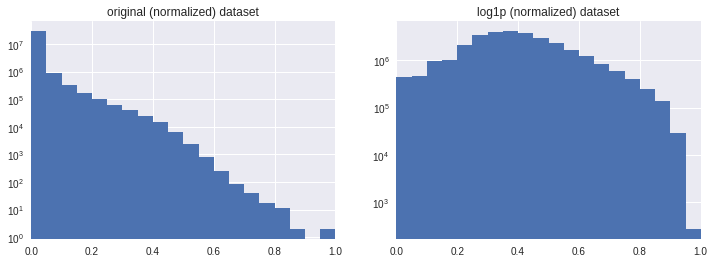

In [4]:
fig, (ax0, ax1) = plt.subplots(1, 2, figsize=(12, 4))
for (ax, data, label) in [(ax0, x_train_exp, "original (normalized) dataset"),
                          (ax1, x_train, "log1p (normalized) dataset")]:
    ax.hist(np.ndarray.flatten(data), range=(0,1), bins=20)
    ax.set_title(label)
    ax.set_yscale("log")
    ax.set_xlim(0, 1)

## Model definition

I use a `get_model` function that will make it easier to tweak hyperparameters. A description of the model is [available here](https://www.kaggle.com/cdeotte/25-million-images-0-99757-mnist#Architectural-highlights). To summarize:

- The model starts of with two stacked `Conv2D` layers with `kernel_size=3` that are supposed to be equivalent to a single Conv2D layer with `kernel_size=5` with nonlinear convolutions.
- Next, a `Conv2D` layer with `strides=2` is added that is supposed to act as a (learnable) pooling layer. Thus, the model does not make use of any classical pooling layers.
- A `Dropout` layer is used next.
- The models are repeated once, but with a feature number of 64 instead of 32.
- A final `Conv2D` layer is added.
- Each `Conv2D` layer is followed by a `BatchNormalization` layer.
- `Flatten` and another `Dropout` are added.
- Finally, a `Dense` layer is used to output the result.

In [4]:
def add_module(model, features, dropout, **kwargs):
    model.add(Conv2D(features, kernel_size=3, padding="same", activation="relu", **kwargs))
    model.add(BatchNormalization())
    model.add(Conv2D(features, kernel_size=3, padding="same", activation="relu"))
    model.add(BatchNormalization())
    model.add(Conv2D(features, kernel_size=5, strides=2, padding="same", activation="relu"))
    model.add(BatchNormalization())
    model.add(Dropout(dropout))

def get_model(dropout=0.4, dropout_final=0.4, last_features=128):
    model = tf.keras.Sequential()
    
    add_module(model, 32, dropout, input_shape=(16, 16, 1))
    add_module(model, 64, dropout)

    model.add(Conv2D(last_features, kernel_size=4, activation="relu"))
    model.add(BatchNormalization())
    model.add(Flatten())
    model.add(Dropout(dropout_final))
    model.add(Dense(1, activation="sigmoid"))

    model.compile(
        optimizer='adam',
        loss='binary_crossentropy',
        metrics=['accuracy'],
    )
    
    return model

This is, what a typical model looks like:

In [5]:
get_model().summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d (Conv2D)              (None, 16, 16, 32)        320       
_________________________________________________________________
batch_normalization (BatchNo (None, 16, 16, 32)        128       
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 16, 16, 32)        9248      
_________________________________________________________________
batch_normalization_1 (Batch (None, 16, 16, 32)        128       
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 8, 8, 32)          25632     
_________________________________________________________________
batch_normalization_2 (Batch (None, 8, 8, 32)          128       
_________________________________________________________________
dropout (Dropout)            (None, 8, 8, 32)          0         
__________

I am going to use the following training parameters during training.

In [5]:
# Training parameters
batch_size = 64
epochs = 32

## Evaluation of data scaling

In [7]:
model = get_model()

scaletest_start = model.get_weights()
training_output_log1p = model.fit(
    x=x_train, y=y_train,
    validation_data=(x_val, y_val),
    batch_size=batch_size,
    epochs=20)

model.set_weights(scaletest_start)
training_output_orig = model.fit(
    x=x_train_exp, y=y_train,
    validation_data=(x_val_exp, y_val),
    batch_size=batch_size,
    epochs=20)

Train on 120000 samples, validate on 40000 samples
Epoch 1/20
120000/120000 [==============================] - 34s 283us/step - loss: 0.1963 - acc: 0.9294 - val_loss: 0.1057 - val_acc: 0.9691
Epoch 2/20
120000/120000 [==============================] - 31s 255us/step - loss: 0.1147 - acc: 0.9658 - val_loss: 0.8890 - val_acc: 0.6506
Epoch 3/20
120000/120000 [==============================] - 31s 259us/step - loss: 0.1000 - acc: 0.9712 - val_loss: 0.2263 - val_acc: 0.9195
Epoch 4/20
120000/120000 [==============================] - 31s 255us/step - loss: 0.0920 - acc: 0.9743 - val_loss: 0.0982 - val_acc: 0.9713
Epoch 5/20
120000/120000 [==============================] - 31s 255us/step - loss: 0.0893 - acc: 0.9754 - val_loss: 0.1585 - val_acc: 0.9434
Epoch 6/20
120000/120000 [==============================] - 30s 253us/step - loss: 0.0852 - acc: 0.9768 - val_loss: 0.0745 - val_acc: 0.9804
Epoch 7/20
120000/120000 [==============================] - 31s 258us/step - loss: 0.0796 - acc: 0.9787

(<Figure size 1008x432 with 2 Axes>,
 array([<matplotlib.axes._subplots.AxesSubplot object at 0x7fd48c190358>,
       dtype=object))

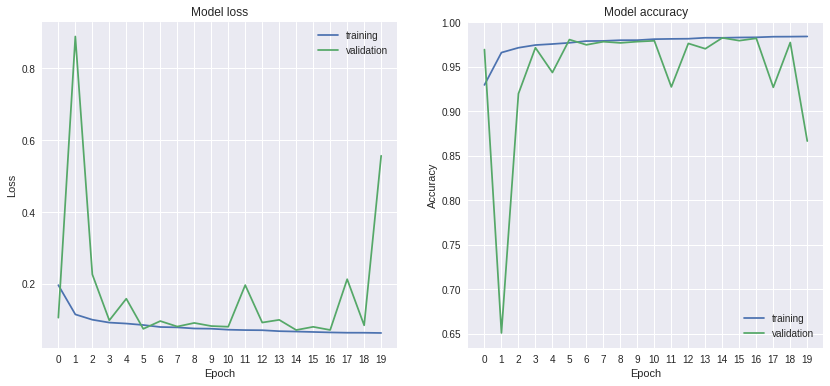

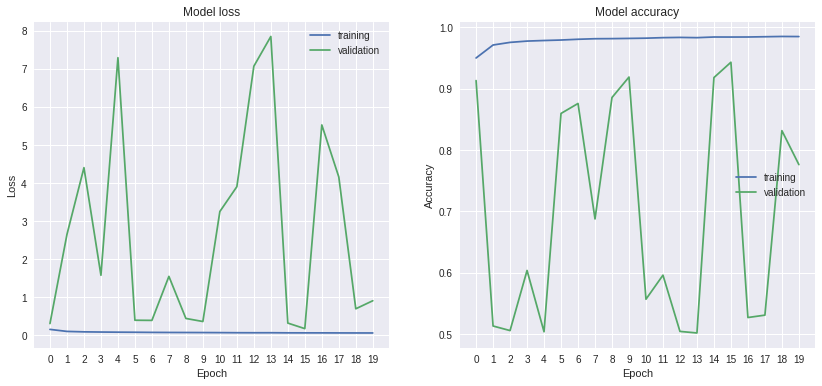

In [9]:
plot_history(training_output_log1p)
plot_history(training_output_orig)

The results of both fit attempts indicate several things:

- In both cases, very high training accuracies of up to 98.5% are achieved, well above the target of 97%.
- In both cases, the traning accuracy of the last two epoch is the highest, indicating that the fits are not yet convered and we can do even better
- The validation accuracy of the unscaled dataset is much worse than the training accuracy, indicating problems with overfitting.
- Model is too large for data, apply stronger regularization

### Data augmentation

More data is always better, and since the 200k datasets resulted in much better and more consistent results than the 10k dataset, I extrapolate that that even more samples would be even better.

Mirroring the images horizontally and/or vertically should still produce valid training data, but is going to increase the size of the training set from 120k to 480k

In [6]:
datagen_exp = tf.keras.preprocessing.image.ImageDataGenerator(
    horizontal_flip=True,
    vertical_flip=True
)
datagen_exp.fit(x_train_exp)

datagen = tf.keras.preprocessing.image.ImageDataGenerator(
    horizontal_flip=True,
    vertical_flip=True
)
datagen.fit(x_train)

In [8]:
def train_test_model(
    datagen, x_train, y_train, x_val, y_val,
    dropout=0.4, dropout_final=0.4, last_features=128
):
    model = get_model(dropout, dropout_final, last_features)
    training_output = model.fit(
        datagen.flow(x_train, y_train, batch_size=batch_size),
        validation_data=(x_val, y_val),
        epochs=epochs,
        verbose=0)
    
    pred = model.predict([x_val])
    result = pred > 0.5
    accuracy = accuracy_score(y_val, result)
    print("dropout={:.1f} dropout_final={:.1f} last_features={:3d}    accuracy={:.5f}".format(
        dropout, dropout_final, last_features, accuracy
    ))
    return {
        "dropout": dropout,
        "dropout_final": dropout_final,
        "last_features": last_features,
        "loss": training_output.history["loss"],
        "val_loss": training_output.history["val_loss"],
        "acc": training_output.history["acc"],
        "val_acc": training_output.history["val_acc"],
        "accuracy": accuracy,
        "confmat": confusion_matrix(y_val, result),
        "f1": f1_score(y_val, result),
        "mcc": matthews_corrcoef(y_val, result),
    }

## Hyperparameter tuning

I decided to do some hyperparameter tuning to find the model that is most suitable for the present problem.
Because the CeBr image problem is less complex than the MNIST problem (smaller images, only binary classification, more homogeneous data),
I suspect that it makes sense to increase the dropout for better regularization and to reduce the complexity of the model,
for example by decreasing the number of features in the final `Conv2D` layer.

I decided to train and compare a total of 18 different models

In [ ]:
hp_params = [
    [dropout, dropout_final, last_features]
    for dropout in [0.4, 0.5, 0.6]
    for dropout_final in [0.4, 0.5, 0.6]
    for last_features in [64, 128]
]

# I had problems with tensorflow reserving all the GPUs memory at once.
# Creating a new process for each model solves the problem
with contextlib.closing(Pool(1)) as po:
    pool_results = po.starmap(
        train_test_model,
        [(datagen, x_train, y_train, x_val, y_val, dropout, dropout_final, last_features)
         for dropout, dropout_final, last_features in hp_params]
    )
    hp_search = pd.DataFrame(pool_results)
hp_org = hp_search.set_index(["dropout", "dropout_final", "last_features"])
hp_search["acc_min"] = hp_search.val_acc.apply(lambda x: np.min(np.array(x)[-5:]))
hp_search.to_pickle("cnn_gs.pickle")

In [56]:
hp_search[["dropout", "dropout_final", "last_features", "accuracy", "f1", "mcc", "confmat"]]

,dropout,dropout_final,last_features,accuracy,f1,mcc,confmat
0,0.4,0.4,64,0.953425,0.954818,0.908372,"[[18452, 1512], [351, 19685]]"
1,0.4,0.4,128,0.975025,0.974753,0.950353,"[[19716, 248], [751, 19285]]"
2,0.4,0.5,64,0.983300,0.983200,0.966717,"[[19785, 179], [489, 19547]]"
3,0.4,0.5,128,0.847700,0.865974,0.721907,"[[14227, 5737], [355, 19681]]"
4,0.4,0.6,64,0.956350,0.957460,0.913772,"[[18605, 1359], [387, 19649]]"
5,0.4,0.6,128,0.949100,0.950669,0.899810,"[[18346, 1618], [418, 19618]]"
6,0.5,0.4,64,0.985125,0.984989,0.970481,"[[19884, 80], [515, 19521]]"
7,0.5,0.4,128,0.981600,0.981462,0.963366,"[[19781, 183], [553, 19483]]"
8,0.5,0.5,64,0.983400,0.983296,0.966925,"[[19792, 172], [492, 19544]]"
9,0.5,0.5,128,0.983800,0.983658,0.967815,"[[19850, 114], [534, 19502]]"


To get a better understanding of the stability of the results (with respect to overfitting),
I visualize the minimum validation accuracy that was obtained during the last 5 epochs:

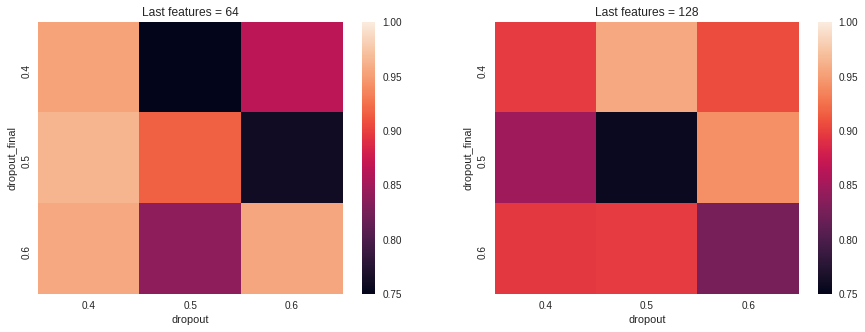

In [34]:
fig, axs = plt.subplots(1, 2, figsize=(15, 5))
for features, ax in [(64, axs[0]), (128, axs[1])]:
    df2 = hp_search[hp_search["last_features"]==features].pivot(
        columns='dropout', index="dropout_final", values="acc_min")
    sns.heatmap(df2, ax=ax, vmin=0.75, vmax=1.0)
    ax.set_title("Last features = {}".format(features))

For 64 features, a dropout of 0.4 for the convolutional layers seems to be preferred.
For 128 features, no clear pattern emerges.

Next, I plot the history of accuracy and validation accuracy:

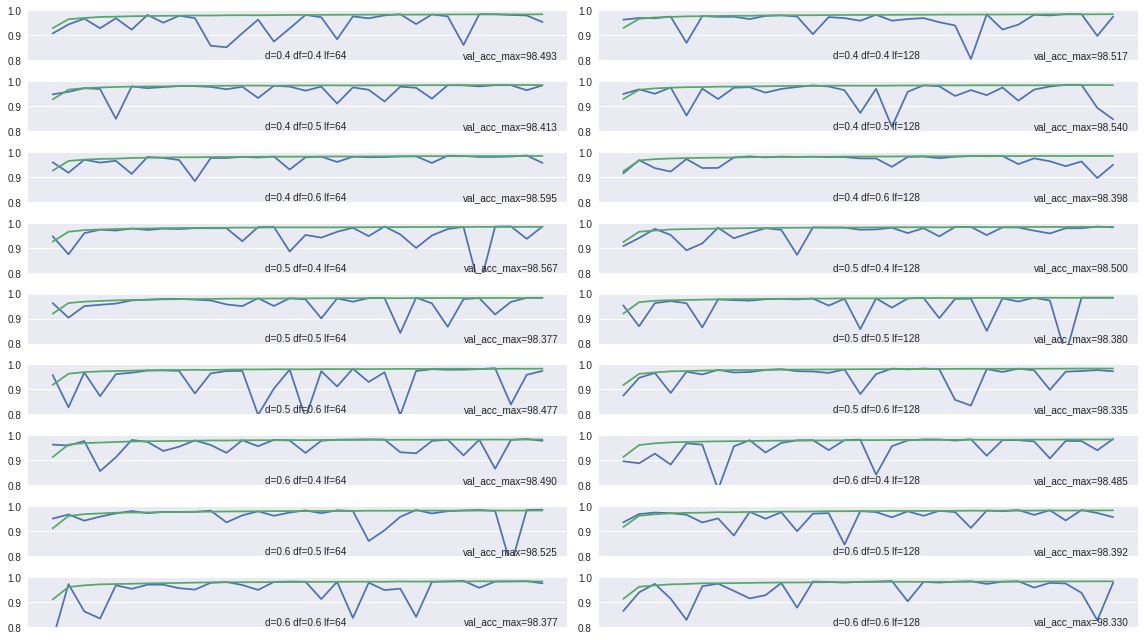

In [58]:
fig, axs = plt.subplots(9, 2, figsize=(16, 9))
axs = np.ndarray.flatten(axs)
for i, d in hp_search.iterrows():
    axs[i].plot(range(len(d.val_acc)), d.val_acc)
    axs[i].plot(range(len(d.acc)), d.acc)
    axs[i].get_xaxis().set_visible(False)
    axs[i].set_ylim(0.8, 1.)
    axs[i].text(16, 0.8,
                "d={:.1f} df={:.1f} lf={}".format(
                    d.dropout, d.dropout_final, d.last_features
                ), ha="center", va="bottom")
    axs[i].text(32, 0.8,
                "val_acc_max={:.3f}".format(
                    100*np.max(d.val_acc)
                ), ha="right", va="bottom")
plt.tight_layout()
plt.show()

Overall, the best (maximum) validation accuracy is obtained by the hyperparameter combination of `dropout=0.4`, `dropout_final=0.6`, `last_features=64`,
with a maximum validation accuracy of 98.595%.
This model also displays the smallest signs of overfitting, i.e. it is able to consistently reach high validation accuracies.

To see, if this model can do even better, I increase the number of epochs to 45 and fit again:

In [7]:
checkpoint = tf.keras.callbacks.ModelCheckpoint(
    "training/weights.{epoch:02d}_{val_acc:.5f}.hdf5",
    monitor='val_acc', period=1)

In [8]:
best_hp = (0.4, 0.6, 64)
model = get_model(*best_hp)
print(model.summary())
training_output = model.fit(
    datagen.flow(x_train, y_train, batch_size=batch_size),
    validation_data=(x_val, y_val),
    callbacks=[checkpoint],
    epochs=45)

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d (Conv2D)              (None, 16, 16, 32)        320       
_________________________________________________________________
batch_normalization (BatchNo (None, 16, 16, 32)        128       
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 16, 16, 32)        9248      
_________________________________________________________________
batch_normalization_1 (Batch (None, 16, 16, 32)        128       
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 8, 8, 32)          25632     
_________________________________________________________________
batch_normalization_2 (Batch (None, 8, 8, 32)          128       
_________________________________________________________________
dropout (Dropout)            (None, 8, 8, 32)          0         
__________

(<Figure size 1008x432 with 2 Axes>,
 array([<matplotlib.axes._subplots.AxesSubplot object at 0x7fbb813d70b8>,
       dtype=object))

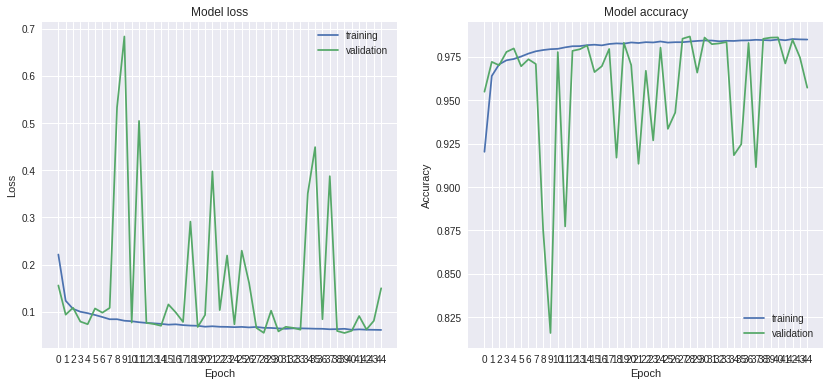

In [9]:
plot_history(training_output)

The model accuracy is still jumping around, so there is probably still some overfitting going on.
The best validation accuracies and validation losses are achieved around epoch 30, so it does not seem to be beneficial to train for 45 epochs.
The epoch 29 reaches a validation accuracy of 98.66%, which is significantly better than the target of 97%.
Out ot 45 epochs, 27 reach validation accuracies of 97% or higher, 14 reach 98% or higher and 6 reach 98.5% or higher.

For further analysis of the results, I will rollback to epoch 29.
I copied the model data to the file `weights_best.hdf5`.

In [28]:
model.load_weights("weights_best.hdf5")

## Collection of metrics

In [30]:
pred = model.predict([x_val])
result = pred > 0.5
accuracy = accuracy_score(y_val, result)
confmat = confusion_matrix(y_val, result)
f1 = f1_score(y_val, result)
mcc = matthews_corrcoef(y_val, result)

In [34]:
print("""Confusion matrix:\n{}
Accuracy: {:.4f}
F1-score: {:.4f}
MCC: {:.4f}""".format(
confmat, accuracy, f1, mcc))

Confusion matrix:
[[19867    53]
 [  482 19598]]
Accuracy: 0.9866
F1-score: 0.9865
MCC: 0.9735


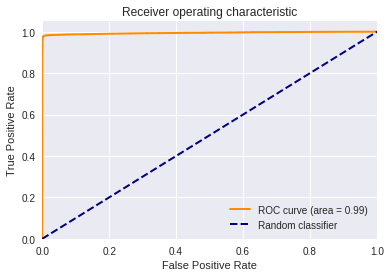

In [33]:
plot_roc_auc(y_val, pred)

In [35]:
def perf_measure(y_actual, y_hat):
    TP = []
    FP = []
    TN = []
    FN = []

    for i in range(len(y_hat)):
        if y_actual[i]==y_hat[i]==1:
           TP.append(i)
        if y_hat[i]==1 and y_actual[i]!=y_hat[i]:
           FP.append(i)
        if y_actual[i]==y_hat[i]==0:
           TN.append(i)
        if y_hat[i]==0 and y_actual[i]!=y_hat[i]:
           FN.append(i)

    return TP, FP, TN, FN

In [36]:
pos_val = positions[val_idx]
TP, FP, TN, FN = perf_measure(y_val, result)

In [113]:
def plot_measure(measure):
    fig, axs = plt.subplots(6, 8, figsize=(16,12))
    viridis = mpl.cm.get_cmap('viridis', 256)
    axs = axs.flat
    for i, ax in enumerate(axs):
        idx = measure[i]
        ax.imshow(np.log1p(x_val[idx].T[0].T), cmap=viridis)
        ax.axes.get_xaxis().set_visible(False)
        ax.axes.get_yaxis().set_visible(False)
        ax.autoscale(False)
        ax.text(.5, .5, idx, ha="left", va="top", color="white")
        ax.text(14.5, .5, "{:.2f}".format(pred[idx][0]), ha="right", va="top", color="white")
        ax.plot(pos_val[idx, 0], pos_val[idx, 1], "rX")
        ax.plot(pos_val[idx, 2], pos_val[idx, 3], "rX")
    plt.tight_layout()

Let’s start with the positive cases (true positive and true negative) to verify that I am actually plotting everything correctly.

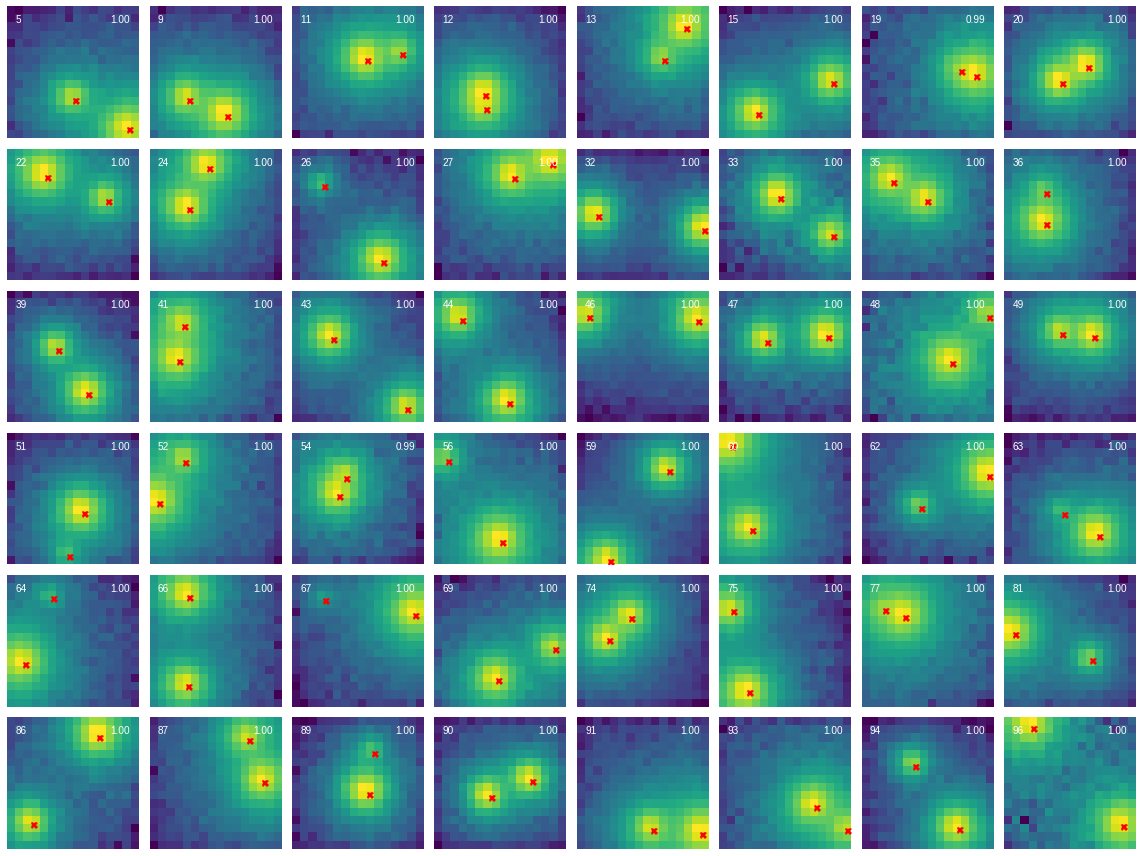

In [117]:
plot_measure(TP)

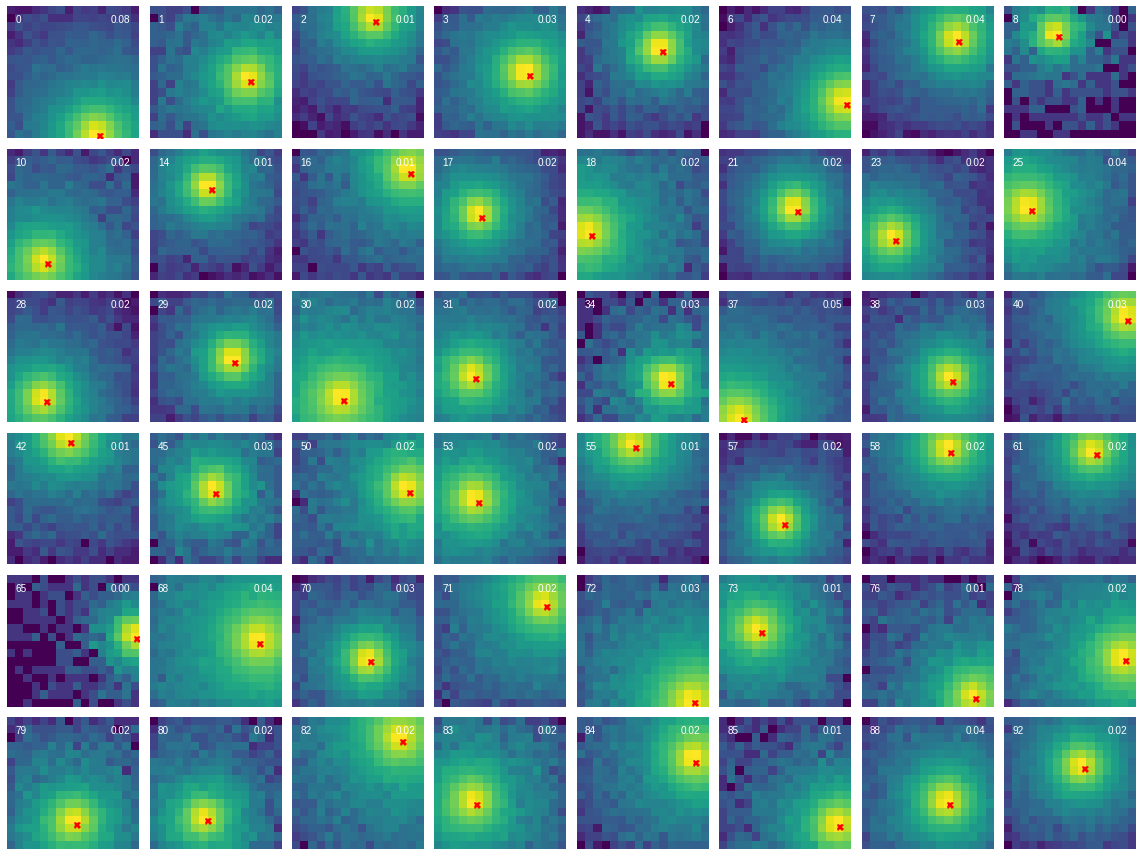

In [118]:
plot_measure(TN)

The plots look as expected. In some cases, such as case 12 and 19, the model is even able to correctly classify images where a human would have problems.

So, where does the model fail to see two peaks, i.e., what are examples for false negatives?

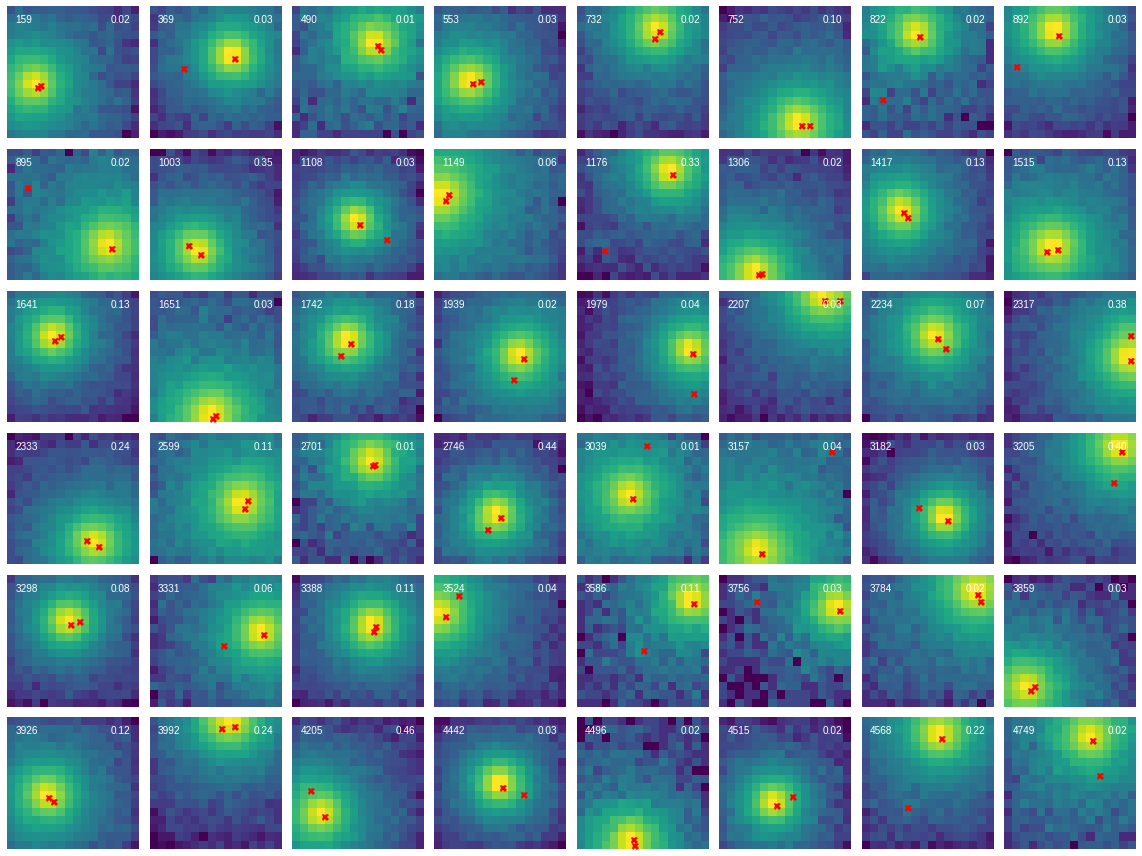

In [119]:
plot_measure(FN)

It can be seen that all of these are cases, where both spots are either extremly close together or one spot is significantly brighter than the other one.
In all of the shown images, a human would probably agree with the result obtained by the model. In total, there are 482 or 1.2% false negatives.

Finally, we come to the last category, false positives, where the model incorrectly sees two peaks, although it should only identify a single one.

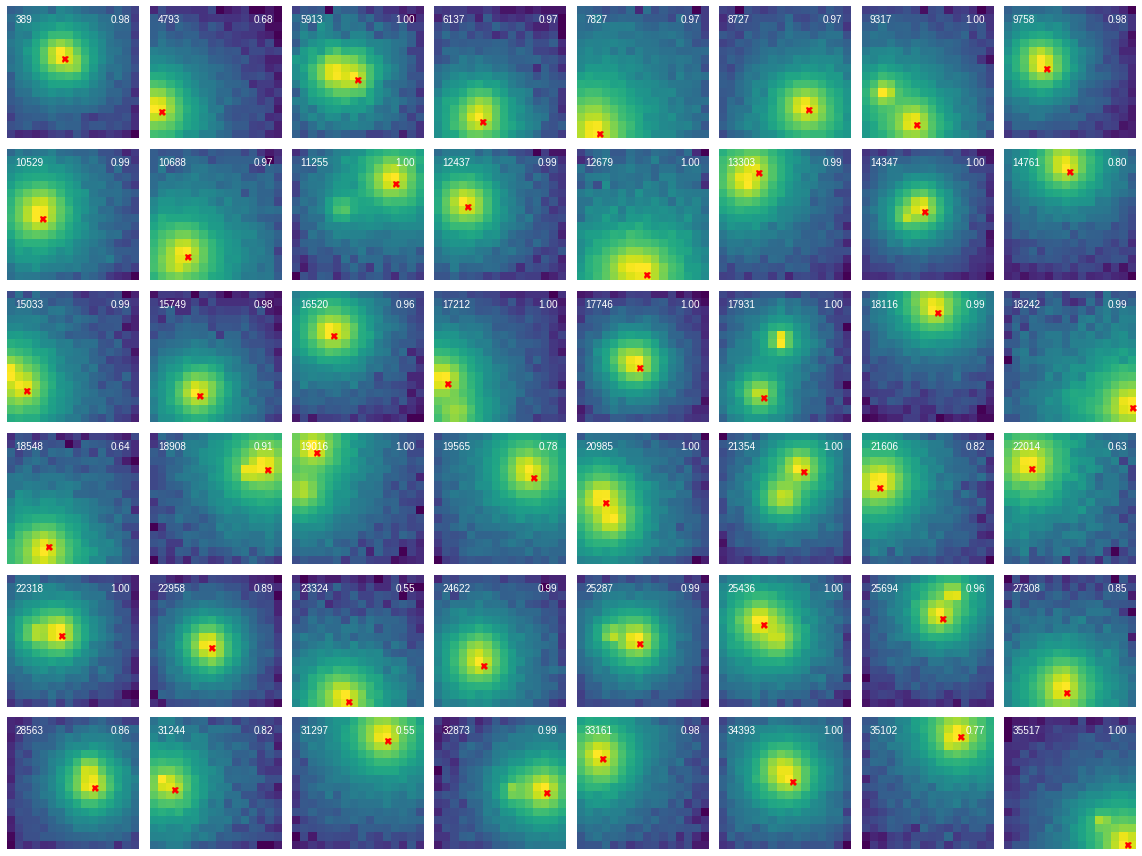

In [123]:
plot_measure(FP)

I had to double-check what I am seeing here. Almost all of the 53 false negatives (0.13%) can be seen above. And in most cases, I am as confused as the model: There are in fact two peaks visible in these images!

After carefully checking the data preparation and plotting code, I came to the conclusion that these images are indeed all labelled to have only a single peak. I assume that the electron is scattered in the detector and/or produces secondary radiation that results in two peaks at different positions.

Overall, the performance of the model (98.7% validation accuracy) is very impressive and I think that it does not perform significantly worse (maybe even better) than a human would do.

## Outlook

The validation accuracy is still jumping around a bit, so it might make sense to apply even stronger regularization, for example by further increasing the dropout.
This should prevent the occasional drops in validation accuracy during training.
The hyperparameter grid search was somewhat coarse so far and could also be improved by using smaller step sizes for the dropout and by training the model several times for each set of hyperparameters to obtain a better understanding of the hyperparameter landscape.
I am also surprised that there is no `Dense` layer (besides the output layer) to process the results of the convolutional layers.
Maybe, one could try to use a `Dense` layer instead of the last `Conv2D` layer.
Finally, it would make sense to validate the results using the test data (that was not touched so far) after all hyperparameters are tuned.

Furthermore, it should be possible to further increase the accuracy by using a combined model that also takes traces into account. This should also address the problem of images that obviously contain two peaks but are labelled to only have one peak.
Maybe, it even makes sense to exclude these images during training, because they are probably confusing the model.